In [1]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [4]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [5]:
def plot(image, target):
    plt.imshow(image, cmap="hot")
    plt.title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'
    plt.show()

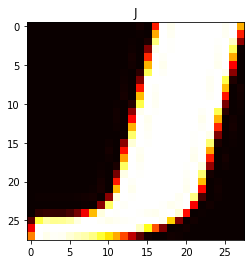

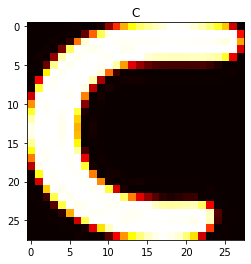

In [6]:
plot(trainData[0], trainTarget[0])
plot(trainData[1], trainTarget[1])

In [7]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

In [8]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w)

In [9]:
def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return sum(y_pred == y) / y.shape[0]

# 1 Linear Regression
### 1. Loss Function and Gradient

In [10]:
# Mean Squared Error Loss
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) #+ reg * np.linalg.norm(w)
    b_grad = 2/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

"""
X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

gradMSE(w, b, X, y, 0.1)
"""


'\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ngradMSE(w, b, X, y, 0.1)\n'

### 2. Gradient Descent Implementation

In [35]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, validData=None, validTarget=None, testData=None, testTarget=None):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    printing = True
    for i in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if validData != None and validTarget != None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if testData != None and testTarget != None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            valid_acc.append( accuracy(w, b, testData, testTarget) )
        
        # Print Losses if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1]*100:.2f}%")
            if validData != None and validTarget != None:
                print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
            if testData != None and testTarget != None:
                print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

        # Check stopping condition
        if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = [train_loss, train_acc]
    if validData != None and validTarget != None:
        statistics += [valid_loss, valid_acc]
    if testData != None and testTarget != None:
        statistics += [test_loss, test_acc]
    statistics = tuple(statistics)
    out = [w, b, *statistics]
        
    return tuple(out)

X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)
w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.001, 10, 0, 0.01)
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics
print(statistics)

Training loss: 12633.6270	Training acc: 50.20%
Training loss: 6707.9524	Training acc: 50.20%
Training loss: 3590.1831	Training acc: 50.20%
Training loss: 1948.5570	Training acc: 50.20%
Training loss: 1083.0658	Training acc: 50.20%
Training loss: 625.7537	Training acc: 49.43%
Training loss: 383.1943	Training acc: 45.26%
Training loss: 253.6972	Training acc: 39.86%
Training loss: 183.7916	Training acc: 37.00%
Training loss: 145.3535	Training acc: 35.80%
[[12633.626990206369, 6707.952426420478, 3590.183123561541, 1948.5569634281787, 1083.0658148826612, 625.7536989205273, 383.19428103142474, 253.6971984816857, 183.79157189815126, 145.3534813834465], [0.502, 0.502, 0.502, 0.502, 0.502, 0.4942857142857143, 0.45257142857142857, 0.3985714285714286, 0.37, 0.358]]


### 3. Tuning the Learning Rate

In [21]:
# functions to plot loss and accuracy
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None):
    if train_loss != None:
        plt.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        plt.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        plt.plot(x, test_loss, label="Testing Loss")
    
    if title == None:
        plt.title("Training Loss")
    else:
        plt.title(title)
    
    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None):
    if train_accuracy != None:
        plt.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        plt.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        plt.plot(x, test_accuracy, label="Testing Accuracy")
    
    if title == None:
        plt.title("Accuracy")
    else:
        plt.title(title)

    plt.xlabel("Epochs")
    plt.xlim(left=0)
    plt.ylabel("Accuracy")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(linestyle='-', axis='y')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

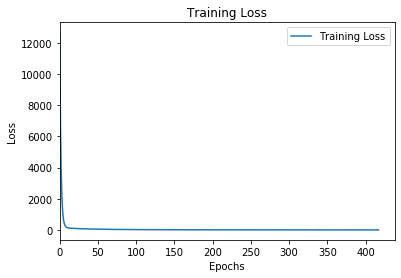

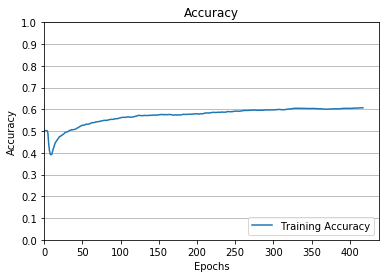

In [28]:
plot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)
plot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)

### 4. Generalization

In [ ]:
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.

### 5. Comparing Batch GD with normal equation

In [ ]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    if N < d:
        return X.T.dot(np.linalg.inv( np.dot(X, X.T) )).dot(y)
    else:
        return np.linalg.inv( np.dot(X.T, X) ).dot(X.T).dot(y)
        
# compare above to gradient descent solution

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

In [ ]:
# this will work for both scalar and vector z
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Cross Entropy Loss
def crossEntropyLoss(W, b, x, y, reg):
    
    X, W = augment(X, W, b)
    
    y_hat = sigmoid(x.dot(W) + b)
    L = np.vectorize(lambda x,y: -np.log(x) if y == 1 else -np.log(1-x))(y_hat, y)
    #... not finished

def gradCE(W, b, x, y, reg):
    # Your implementation here
    pass

### 2. Learning

In [ ]:
def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, lossType="MSE"):
    if lossType == "MSE":
        return grad_descent_MSE(W, b, x, y, alpha, epochs, reg, error_tol)
    elif lossType == "CE":
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

### 3. Comparision to Linear Regression

In [ ]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [ ]:
def buildGraph(loss="MSE"):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    if loss == "MSE":
        # Your implementation
        pass
    elif loss == "CE":
        #Your implementation here
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

### 2. Implementing Stochastic Gradient Descent

In [ ]:
# Implement the SGD algorithm for a minibatch size of 500 
# optimizing over 700 epochs 2, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.

### 3. Batch Size Investigation

### 4. Hyperparameter Investigation

### 5. Cross Entropy Loss Investigation

### 6. Comparison against Batch GD